In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from machines import mps_trotter
from machines import mps_utils
import utils
import scipy

data_dir = "C:/DATA/ClockV2/final_dense"

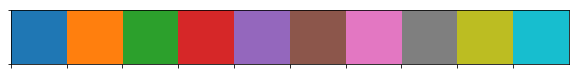

In [10]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 20

cp = sns.color_palette()
sns.palplot(cp)
plt.show()

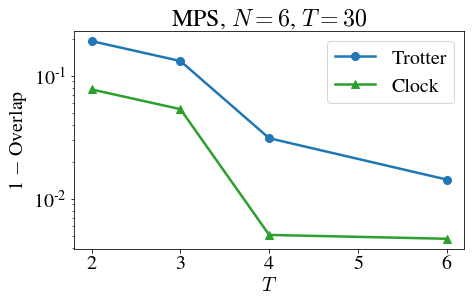

In [39]:
n_sites = 6
h_init = 1.0
h_ev = 0.5

time_steps = 30
t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]

exact_state, exact_obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
pauli = utils.Pauli(exact_state.dtype)

bond_list = [2, 3, 4, 6]

mps_overlaps = []
clock_overlaps = []
for d_bond in bond_list:
    mps = mps_trotter.TFIMTrotterMPS(exact_state[0], d_bond, dt, h=h_ev)
    mps_state = mps.dense_evolution(time_steps)
    mps_overlaps.append(utils.averaged_overlap(exact_state, mps_state))
    
    clock_state = np.load("{}/allstates_mpsD{}_N{}M{}.npy".format(data_dir, d_bond, n_sites, time_steps))
    clock_overlaps.append(utils.averaged_overlap(exact_state, clock_state))
    
plt.figure(figsize=(7, 4))
plt.title("MPS, $N={}$, $T={}$".format(n_sites, time_steps))
markers = ["o", "s", "^"]
plt.semilogy(bond_list, 1 - np.array(mps_overlaps), color=cp[0], marker=markers[0], markersize=8, linewidth=2.5, label="Trotter")
plt.semilogy(bond_list, 1 - np.array(clock_overlaps), color=cp[2], marker=markers[2], markersize=8, linewidth=2.5, label="Clock")
plt.xlabel("$T$")
plt.ylabel("1 $-$ Overlap")
plt.legend()
plt.show()

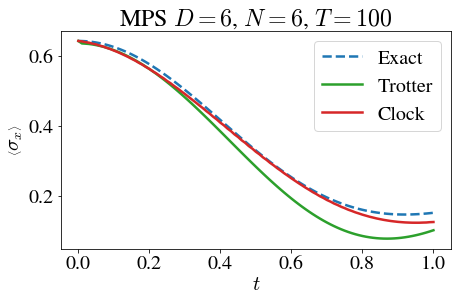

In [37]:
time_steps = 100
t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]
d_bond = 6

exact_state, exact_obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

mps = mps_trotter.TFIMTrotterMPS(exact_state[0], d_bond, dt, h=h_ev)
mps_state = mps.dense_evolution(time_steps)
mps_obs = {"X": utils.ev_local(mps_state, pauli.X)}

clock_state = np.load("{}/allstates_mpsD{}_N{}M{}.npy".format(data_dir, d_bond, n_sites, time_steps))
clock_obs = {"X": utils.ev_local(clock_state, pauli.X)}

plt.figure(figsize=(7, 4))
plt.title("MPS $D={}$, $N={}$, $T={}$".format(d_bond, n_sites, time_steps))
plt.plot(t, exact_obs["X"].real, "--", color=cp[0], linewidth=2.5, label="Exact")
plt.plot(t, mps_obs["X"].real, color=cp[2], linewidth=2.5, label="Trotter")
plt.plot(t, clock_obs["X"].real, color=cp[3], linewidth=2.5, label="Clock")
plt.xlabel("$t$")
plt.ylabel(r"$\left \langle \sigma _x\right \rangle$")
plt.legend()
plt.show()

Unitarity tests

In [5]:
ux = mps_utils.mpo_to_dense(mps.x_op[:, np.newaxis, :, :, np.newaxis])
uz = mps_utils.mpo_to_dense(mps.zz_op)
ident = np.eye(ux.shape[0], dtype=ux.dtype)

diff1 = ux.dot(ux.conj().T) - ident
diff2 = ux.conj().T.dot(ux) - ident
print(diff1.mean(), diff1.real.std(), diff1.imag.std())
print(diff2.mean(), diff2.real.std(), diff2.imag.std())
         
diff1 = uz.dot(uz.conj().T) - ident
diff2 = uz.conj().T.dot(uz) - ident
print(diff1.mean(), diff1.real.std(), diff1.imag.std())
print(diff2.mean(), diff2.real.std(), diff2.imag.std())

(1.0394207867634612e-17+0j) 8.377292388783317e-17 5.711389547647508e-19
(1.0394207867634612e-17+0j) 8.377292388783317e-17 5.711389547647508e-19
(-1.0619760279495516e-16+0j) 8.451117444931175e-16 0.0
(-1.0619760279495516e-16+0j) 8.451117444931175e-16 0.0


Test operator dense forms

In [6]:
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
ham0 = utils.tfim_hamiltonian(n_sites, h=0.0)
hamf = ham - ham0

ux_exact = scipy.linalg.expm(-1j * dt * hamf)
uz_exact = scipy.linalg.expm(-1j * dt * ham0)

diff = ux - ux_exact
print(diff.mean(), diff.real.std(), diff.imag.std())

diff = uz - uz_exact
print(diff.mean(), diff.real.std(), diff.imag.std())

(3.650822625116539e-18+1.4045972379293077e-19j) 3.2664938832301576e-17 7.042863735768505e-19
(-5.231275482242559e-17+1.3213713977167085e-19j) 4.163068918395548e-16 1.1776708927935805e-17
